In [ ]:
!pip3 install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from google.colab import drive

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from scipy.stats import percentileofscore
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from catboost import CatBoostRegressor, cv, Pool

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_excel('/content/drive/MyDrive/dataset1/data_match9.xlsx', engine='openpyxl')
test_data = pd.read_excel('/content/drive/MyDrive/dataset1/data_match10.xlsx', engine='openpyxl')

train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [ ]:
def add_column(data):
    data["B10B-B16B"] = data["B10B"] - data["B16B"]
    data["B11B-IRB"] = data["B11B"] - data["IRB"]
    data["IRB-I2B"] = data["IRB"] - data["I2B"]
    data["WVB-B09B"] = data["WVB"] - data["B09B"]
    data["B09B-B10B"] = data["B09B"] - data["B10B"]

In [ ]:
data = pd.concat([train_data, test_data], ignore_index=True)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data.iloc[:, 6:-1] = scaler.fit_transform(data.iloc[:, 6:-1])

In [ ]:
add_column(data)

In [ ]:
data.iloc[:, -5:] = scaler.fit_transform(data.iloc[:, -5:])

In [ ]:
train_cols = ["IRB", "B10B-B16B", "B11B-IRB", "IRB-I2B", "WVB-B09B", "B09B-B10B", 
              'CAPE', 'TCC', 'TCW', 'TCWV']
x = data[train_cols]
y = data['value']
IMERG = data['IMERG']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
IMERG_train = data['IMERG'].loc[Y_train.index]
IMERG_test = data['IMERG'].loc[Y_test.index]

In [ ]:
def compute_metric(name, model, X, Y):
    print(f'{name}-R2:', model.score(X,Y))
    print(f'{name}-RMSE:',mean_squared_error(Y, model.predict(X), squared=False))
    print(f'{name}-MAE:',mean_absolute_error(Y,model.predict(X)))
    print(f'{name}-Pearson r:', stats.pearsonr(Y, model.predict(X))[0])

In [ ]:
np.random.seed(42)

# LR

In [ ]:
LR = LinearRegression()
LR.fit(X_train,Y_train)

LinearRegression()

In [ ]:
compute_metric('Linear Regression Train', LR, X_train, Y_train)

Linear Regression Train-R2: 0.1013089190917561
Linear Regression Train-RMSE: 2.198786172477575
Linear Regression Train-MAE: 0.6081252433933565
Linear Regression Train-Pearson r: 0.31829062048975976


In [ ]:
compute_metric('Linear Regression Val', LR, X_test, Y_test)

Linear Regression Val-R2: 0.09696719780432617
Linear Regression Val-RMSE: 2.345197441567148
Linear Regression Val-MAE: 0.6299371318547652
Linear Regression Val-Pearson r: 0.31182874912483644


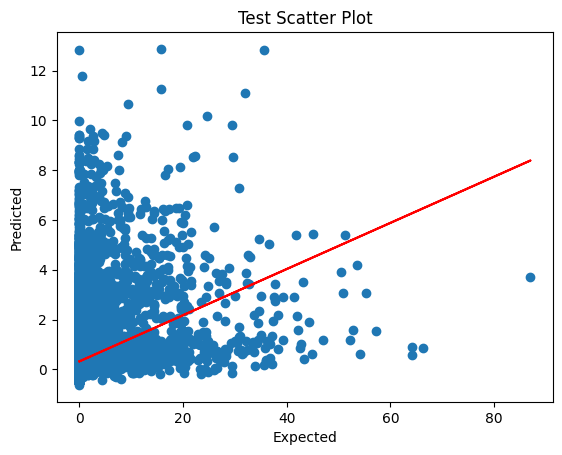

In [ ]:
plt.ylabel('Predicted')
plt.xlabel('Expected')
plt.title('Test Scatter Plot')
plt.plot(Y_test, LR.predict(X_test), 'o')
a, b = np.polyfit(Y_test, LR.predict(X_test), 1)
plt.plot(Y_test, a * Y_test + b, 'r')
plt.show()

# MLP

In [ ]:
MLP = MLPRegressor(max_iter=1000)
MLP.fit(X_train,Y_train)

MLPRegressor(max_iter=1000)

In [ ]:
compute_metric('MLP Regressor Train', MLP, X_train, Y_train)

MLP Regressor Train-R2: 0.14652079287477104
MLP Regressor Train-RMSE: 2.142763568908932
MLP Regressor Train-MAE: 0.5613779543338874
MLP Regressor Train-Pearson r: 0.38423097697509


In [ ]:
compute_metric('MLP Regressor Val', MLP, X_test, Y_test)

MLP Regressor Val-R2: 0.1381267495418278
MLP Regressor Val-RMSE: 2.2911279828332187
MLP Regressor Val-MAE: 0.5855447695299173
MLP Regressor Val-Pearson r: 0.3739517872906831


In [ ]:
mlp_param_grid = {'hidden_layer_sizes': [(50,50,50), (100,1)],
              'activation': ['relu','tanh'],
              'alpha': [0.0001, 0.05],
              'learning_rate': ['constant','adaptive'],
              'solver': ['adam']}
grid_mlp = GridSearchCV(MLP, param_grid=mlp_param_grid, cv=3, n_jobs=-1, verbose=1)
grid_mlp.fit(X_train, Y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=MLPRegressor(max_iter=1000), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (100, 1)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['adam']},
             verbose=1)

In [ ]:
grid_mlp.best_params_

{'activation': 'relu',
 'alpha': 0.05,
 'hidden_layer_sizes': (50, 50, 50),
 'learning_rate': 'constant',
 'solver': 'adam'}

In [ ]:
grid_mlp = MLPRegressor(activation='relu', alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate='constant',solver='adam',random_state=42)
grid_mlp.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(alpha=0.05, hidden_layer_sizes=(50, 50, 50), random_state=42)

In [ ]:
compute_metric('MLP (Grid Search) Train', grid_mlp, X_train, Y_train)

MLP (Grid Search) Train-R2: 0.3110778221471806
MLP (Grid Search) Train-RMSE: 1.9251424227316405
MLP (Grid Search) Train-MAE: 0.512091313932941
MLP (Grid Search) Train-Pearson r: 0.5585670919934949


In [ ]:
compute_metric('MLP (Grid Search) Val', grid_mlp, X_test, Y_test)

MLP (Grid Search) Val-R2: 0.15712439889640917
MLP (Grid Search) Val-RMSE: 2.265736441929389
MLP (Grid Search) Val-MAE: 0.5651284381617752
MLP (Grid Search) Val-Pearson r: 0.41777960955770205


# Decision Tree

In [ ]:
DTR = DecisionTreeRegressor(random_state=42)
DTR.fit(X_train,Y_train)

DecisionTreeRegressor(random_state=42)

In [ ]:
compute_metric('Decision Tree Train', DTR, X_train, Y_train)

Decision Tree Train-R2: 0.9684114944518379
Decision Tree Train-RMSE: 0.41223258847062505
Decision Tree Train-MAE: 0.028366282916501253
Decision Tree Train-Pearson r: 0.984079008236499


In [ ]:
compute_metric('Decision Tree Val', DTR, X_test, Y_test)

Decision Tree Val-R2: -0.36007111327838826
Decision Tree Val-RMSE: 2.8781170814664963
Decision Tree Val-MAE: 0.5427645924675627
Decision Tree Val-Pearson r: 0.29365994137843526


In [ ]:
dt_param_grid = {"max_depth" : [1, 5],
                 "min_samples_leaf":[1, 5],
                 "max_leaf_nodes":[None, 10] }
grid_dt = GridSearchCV(DTR, param_grid=dt_param_grid, cv=3, n_jobs=-1, verbose=1)
grid_dt.fit(X_train, Y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 5], 'max_leaf_nodes': [None, 10],
                         'min_samples_leaf': [1, 5]},
             verbose=1)

In [ ]:
grid_dt.best_params_

{'max_depth': 5, 'max_leaf_nodes': None, 'min_samples_leaf': 5}

In [ ]:
grid_dt = DecisionTreeRegressor(max_depth=5, max_leaf_nodes=None, min_samples_leaf=5,random_state=42)
grid_dt.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=5, random_state=42)

In [ ]:
compute_metric('Decision Tree (Grid Search) Train', grid_dt, X_train, Y_train)

Decision Tree (Grid Search) Train-R2: 0.14474152535003348
Decision Tree (Grid Search) Train-RMSE: 2.1449959400322123
Decision Tree (Grid Search) Train-MAE: 0.535973002653998
Decision Tree (Grid Search) Train-Pearson r: 0.380449110066033


In [ ]:
compute_metric('Decision Tree (Grid Search) Val', grid_dt, X_test, Y_test)

Decision Tree (Grid Search) Val-R2: 0.11741594645568865
Decision Tree (Grid Search) Val-RMSE: 2.3184924546809667
Decision Tree (Grid Search) Val-MAE: 0.5648100204597972
Decision Tree (Grid Search) Val-Pearson r: 0.3435929433522554


# RF

In [ ]:
RFR = RandomForestRegressor(random_state=42)
RFR.fit(X_train,Y_train)

RandomForestRegressor(random_state=42)

In [ ]:
compute_metric('Random Forest Train', RFR, X_train, Y_train)

Random Forest Train-R2: 0.8738606604937416
Random Forest Train-RMSE: 0.8237644725138094
Random Forest Train-MAE: 0.18628044601493615
Random Forest Train-Pearson r: 0.9561961076566089


In [ ]:
compute_metric('Random Forest Val', RFR, X_test, Y_test)

Random Forest Val-R2: 0.25082464676959737
Random Forest Val-RMSE: 2.1360892249288015
Random Forest Val-MAE: 0.48800034586158353
Random Forest Val-Pearson r: 0.5021140394758469


In [ ]:
rfr_param_grid = {'max_depth': [3, 7, None],
                 'min_samples_split': [2, 5, 10],
                 'n_estimators': [100, 200]}
grid_rfr = GridSearchCV(rfr, param_grid=rfr_param_grid, cv=3, n_jobs=-1, verbose=1)
grid_rfr.fit(X_train, Y_train)

In [ ]:
rfr_param_grid.best_params_

In [ ]:
grid_rfr = RandomForestRegressor(max_depth = None, n_estimators = 200, min_samples_leaf = 2, random_state=42)
grid_rfr.fit(X_train, Y_train)

RandomForestRegressor(min_samples_leaf=2, n_estimators=200, random_state=42)

In [ ]:
compute_metric('Random Forest (Grid Search) Train', grid_rfr, X_train, Y_train)

Random Forest (Grid Search) Train-R2: 0.7563374135621393
Random Forest (Grid Search) Train-RMSE: 1.1449122610156872
Random Forest (Grid Search) Train-MAE: 0.25283045582054575
Random Forest (Grid Search) Train-Pearson r: 0.9059481362678952


In [ ]:
compute_metric('Random Forest (Grid Search) Test', grid_rfr, X_test, Y_test)

Random Forest (Grid Search) Test-R2: 0.25654370944187144
Random Forest (Grid Search) Test-RMSE: 2.1279203549916703
Random Forest (Grid Search) Test-MAE: 0.48674233971590597
Random Forest (Grid Search) Test-Pearson r: 0.5065772251941677


In [ ]:
print(f'IMERG-R2:', r2_score(Y_test, IMERG_test))
print(f'RMSE:',mean_squared_error(Y_test, IMERG_test, squared=False))
print(f'MAE:',mean_absolute_error(Y_test,IMERG_test))
print(f'Pearson r:', stats.pearsonr(Y_test, IMERG_test)[0])

IMERG-R2: -2.0165358931165973
RMSE: 4.286293417706298
MAE: 0.9819358930707369
Pearson r: 0.2530627721247858


# XGB

In [ ]:
XGB = XGBRegressor(random_state=42)
XGB.fit(X_train,Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
compute_metric('XGBoost Regressor Train', XGB, X_train, Y_train)

XGBoost Regressor Train-R2: 0.5872948548386365
XGBoost Regressor Train-RMSE: 1.4900392994887557
XGBoost Regressor Train-MAE: 0.40255741747656754
XGBoost Regressor Train-Pearson r: 0.785257482298183


In [ ]:
compute_metric('XGBoost Regressor Val', XGB, X_test, Y_test)

XGBoost Regressor Val-R2: 0.21043648298728124
XGBoost Regressor Val-RMSE: 2.1929119041374103
XGBoost Regressor Val-MAE: 0.5228167499905918
XGBoost Regressor Val-Pearson r: 0.46156999399331844


In [ ]:
xgb_param_grid = {"learning_rate"    : [0.01, 0.10] ,
                  "max_depth"        : [6, 10, 15],
                  "min_child_weight" : [1, 5],
                  "n_estimators"     : [100, 200]}
grid_xgb = GridSearchCV(XGB, param_grid=xgb_param_grid, cv=3, n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, Y_train)

In [ ]:
grid_xgb.best_params_

In [ ]:
grid_xgb = XGBRegressor(max_depth = 15, learning_rate = 0.1, min_child_weight = 5, n_estimators = 200, random_state=42)
grid_xgb.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
compute_metric('XGBoost Regressor (Grid Search) Train', grid_xgb, X_train, Y_train)

XGBoost Regressor (Grid Search) Train-R2: 0.8805596853399469
XGBoost Regressor (Grid Search) Train-RMSE: 0.8015917721985292
XGBoost Regressor (Grid Search) Train-MAE: 0.20653160705656515
XGBoost Regressor (Grid Search) Train-Pearson r: 0.9470107833537529


In [ ]:
compute_metric('XGBoost Regressor (Grid Search) Val', grid_xgb, X_test, Y_test)

XGBoost Regressor (Grid Search) Val-R2: 0.2440363222492986
XGBoost Regressor (Grid Search) Val-RMSE: 2.1457450200448744
XGBoost Regressor (Grid Search) Val-MAE: 0.5058914251177457
XGBoost Regressor (Grid Search) Val-Pearson r: 0.5021575470920933


# CatBoost

In [ ]:
CBR = CatBoostRegressor()
CBR.fit(X_train,Y_train)

Learning rate set to 0.086453
0:	learn: 2.2971931	total: 66.1ms	remaining: 1m 6s
1:	learn: 2.2775613	total: 83.5ms	remaining: 41.7s
2:	learn: 2.2605444	total: 101ms	remaining: 33.5s
3:	learn: 2.2465255	total: 118ms	remaining: 29.4s
4:	learn: 2.2344114	total: 135ms	remaining: 27s
5:	learn: 2.2239445	total: 153ms	remaining: 25.3s
6:	learn: 2.2136071	total: 170ms	remaining: 24.1s
7:	learn: 2.2045399	total: 190ms	remaining: 23.5s
8:	learn: 2.1973810	total: 206ms	remaining: 22.7s
9:	learn: 2.1906905	total: 222ms	remaining: 22s
10:	learn: 2.1845091	total: 239ms	remaining: 21.5s
11:	learn: 2.1787671	total: 255ms	remaining: 21s
12:	learn: 2.1743980	total: 271ms	remaining: 20.6s
13:	learn: 2.1693555	total: 287ms	remaining: 20.2s
14:	learn: 2.1656871	total: 303ms	remaining: 19.9s
15:	learn: 2.1606214	total: 321ms	remaining: 19.7s
16:	learn: 2.1567111	total: 361ms	remaining: 20.9s
17:	learn: 2.1534060	total: 381ms	remaining: 20.8s
18:	learn: 2.1510441	total: 402ms	remaining: 20.8s
19:	learn: 2.14

In [ ]:
compute_metric('CatBoost Regressor Train', CBR, X_train, Y_train)

CatBoost Regressor Train-R2: 0.4862720544210314
CatBoost Regressor Train-RMSE: 1.662433863687221
CatBoost Regressor Train-MAE: 0.44564992495385664
CatBoost Regressor Train-Pearson r: 0.718826362651344


In [ ]:
compute_metric('CatBoost Regressor Val', CBR, X_test, Y_test)

CatBoost Regressor Val-R2: 0.23098248185179304
CatBoost Regressor Val-RMSE: 2.164191889865386
CatBoost Regressor Val-MAE: 0.5303271330518351
CatBoost Regressor Val-Pearson r: 0.480621181878249


In [ ]:
cbr_param_grid = {"depth"    : [11, 15, 16],
                  "learning_rate" : [0.1, 0.2, 0.3],
                  "iterations"     : [10, 50, 100]}
grid_cbr = GridSearchCV(CBR, param_grid=cbr_param_grid, cv=3, n_jobs=-1, verbose=1)
grid_cbr.fit(X_train, Y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0:	learn: 2.2806560	total: 1.66s	remaining: 2m 44s
1:	learn: 2.2442629	total: 3.29s	remaining: 2m 41s
2:	learn: 2.2151109	total: 4.91s	remaining: 2m 38s
3:	learn: 2.1892111	total: 6.52s	remaining: 2m 36s
4:	learn: 2.1639451	total: 8.9s	remaining: 2m 49s
5:	learn: 2.1423622	total: 11.7s	remaining: 3m 2s
6:	learn: 2.1198478	total: 13.4s	remaining: 2m 57s
7:	learn: 2.0995516	total: 15s	remaining: 2m 52s
8:	learn: 2.0810919	total: 16.6s	remaining: 2m 47s
9:	learn: 2.0650979	total: 18.2s	remaining: 2m 43s
10:	learn: 2.0511747	total: 19.8s	remaining: 2m 40s
11:	learn: 2.0353300	total: 21.4s	remaining: 2m 37s
12:	learn: 2.0227993	total: 23.8s	remaining: 2m 39s
13:	learn: 2.0085015	total: 26.5s	remaining: 2m 42s
14:	learn: 1.9959428	total: 28.2s	remaining: 2m 40s
15:	learn: 1.9828414	total: 29.8s	remaining: 2m 36s
16:	learn: 1.9737085	total: 31.5s	remaining: 2m 33s
17:	learn: 1.9640422	total: 33.1s	remaining: 2m 30s
18:	learn: 1.9545216	total: 34.7s	remaining: 2m 27s
19:	learn: 1.9424676	total

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f14906c9b40>,
             n_jobs=-1,
             param_grid={'depth': [11, 15, 16], 'iterations': [10, 50, 100],
                         'learning_rate': [0.1, 0.2, 0.3]},
             verbose=1)

In [ ]:
grid_cbr.best_params_

{'depth': 15, 'iterations': 100, 'learning_rate': 0.1}

In [ ]:
grid_cbr = CatBoostRegressor(depth = 10, iterations = 200, learning_rate = 0.2, random_state=42)
grid_cbr.fit(X_train, Y_train)

0:	learn: 2.2585258	total: 84.4ms	remaining: 16.8s
1:	learn: 2.2134078	total: 200ms	remaining: 19.8s
2:	learn: 2.1836518	total: 307ms	remaining: 20.2s
3:	learn: 2.1584292	total: 392ms	remaining: 19.2s
4:	learn: 2.1368802	total: 592ms	remaining: 23.1s
5:	learn: 2.1195479	total: 764ms	remaining: 24.7s
6:	learn: 2.1020819	total: 903ms	remaining: 24.9s
7:	learn: 2.0913725	total: 1.04s	remaining: 24.9s
8:	learn: 2.0805696	total: 1.13s	remaining: 24s
9:	learn: 2.0693666	total: 1.22s	remaining: 23.2s
10:	learn: 2.0578698	total: 1.3s	remaining: 22.3s
11:	learn: 2.0478455	total: 1.44s	remaining: 22.5s
12:	learn: 2.0382982	total: 1.57s	remaining: 22.6s
13:	learn: 2.0291243	total: 1.75s	remaining: 23.2s
14:	learn: 2.0184203	total: 1.86s	remaining: 22.9s
15:	learn: 2.0099620	total: 2s	remaining: 23.1s
16:	learn: 2.0065976	total: 2.15s	remaining: 23.1s
17:	learn: 2.0015426	total: 2.33s	remaining: 23.6s
18:	learn: 1.9926965	total: 2.48s	remaining: 23.7s
19:	learn: 1.9890332	total: 2.65s	remaining: 2

In [ ]:
compute_metric('CatBoost Regressor (Grid Search) Train', grid_cbr, X_train, Y_train)

CatBoost Regressor (Grid Search) Train-R2: 0.5707605221335779
CatBoost Regressor (Grid Search) Train-RMSE: 1.519594140766113
CatBoost Regressor (Grid Search) Train-MAE: 0.4166025642171788
CatBoost Regressor (Grid Search) Train-Pearson r: 0.7765917961162732


In [ ]:
compute_metric('CatBoost Regressor (Grid Search) Val', grid_cbr, X_test, Y_test)

CatBoost Regressor (Grid Search) Val-R2: 0.22849332460949245
CatBoost Regressor (Grid Search) Val-RMSE: 2.1676915902337157
CatBoost Regressor (Grid Search) Val-MAE: 0.5306031317165472
CatBoost Regressor (Grid Search) Val-Pearson r: 0.47815756989367053
